
## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import time
from math import sqrt,ceil
from pathlib import Path
import sys
np.set_printoptions(threshold=sys.maxsize)

## Assemble Coefficient Matrix


In [2]:
def assemble_matrix(Nx,Ny,Lx,Ly,shear,rho,scaleFactor,dt):
    
    dx = Lx/Nx
    dy = Ly/Ny
    M = int(Nx*Ny)
    
    #-----COEFFICIENTS----
    #X-MOM and Y_MOM
    #velocities
    ax = dt*shear*dy/dx
    ay = dt*shear*dx/dy

    ap = -2*(ax+ay)
    g = 9.81#gravity
    
    #CONTINUITY
    #velocities and pressure gradients momentum
    ex = dy/2
    ey = dx/2

    
    #smoothing term
    D = scaleFactor*dx*dy/(ap)

    #LHS Pressure Gradient
    Sx = (D*dy)/dx
    Sy = (D*dx)/dy
    Sp = -2*(Sx+Sy)

    
    eqs = 3 #3 equations (momentum x, y and continuity)
    
    #Initialise coefficient matrix
    A = np.zeros((eqs*M, eqs*M))
     #Initialise source vector
    b = np.zeros((eqs*M, 1))
   
    internal = (Nx-2)*(Ny-2)
    corners = 4
    sides =  (2*Nx+2*Ny-8)
    numNonZeros = int(16*sides+4*14+23*internal) #16 by sides, 14 by corners, 23 by internals

    data = np.zeros((numNonZeros))
    row_idx = np.zeros((numNonZeros ))
    col_idx = np.zeros((numNonZeros ))
    
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    
    #Loop through each cell i

    coeffi=0
    for i in range(0, eqs*M, eqs):
        
        #CORNERS
        #bottom left
        if i == 0:
            #X-MOM

            #vpx
            data[coeffi] = ap-ax-ay 
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            #Pp
            data[coeffi] = dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*g*dx*dy
            #LHS
            
            #vpy
            data[coeffi] = ap-ax-ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -dx
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = dx  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#
            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
        #bottom right
        elif i == botright:
            #X-MOM
            #-------#
    
            #vpx
            data[coeffi] = ap-ax-ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            #Pp
            data[coeffi] = -dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*g*dx*dy
            #LHS
            
            #vpy
            data[coeffi] = ap-ax-ay
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -dx
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = dx  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#
 
            #LHS
            
            #vpx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            
        #Top Left
        elif i == topleft:
            #X-MOM
            
            #vpx
            data[coeffi] = ap-ax-ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pp
            data[coeffi] = dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*g*dx*dy
            #LHS
            
            #vpy
            data[coeffi] = ap-ax-ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = dx
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -dx  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
     
            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
        #top right
        elif i == topright:
            #X-MOM

            #vpx
            data[coeffi] = ap-ax-ay 
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*g*dx*dy
            #LHS
            
            #vpy
            data[coeffi] = ap-ax-ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = dx
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -dx  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
       
        #SIDES
        #bottom
        elif 0 < i < botright:
            #X-MOM
            #-------#
            #vpx
            data[coeffi] = ap-ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*g*dx*dy
            #LHS
            #vpy
            data[coeffi] = ap-ay   
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -dx
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = dx  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
            #CONTINUITY
            #-------#

            #LHS
            
            #vpy
            data[coeffi] = ey 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
           
        #top
        elif topleft < i < topright:
            #X-MOM
      
            #vpx
            data[coeffi] = ap-ay   
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*g*dx*dy
            #LHS
            
            #vpy
            data[coeffi] =ap-ay 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = dx
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -dx  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
        #left / Inlet
        elif i in range(eqs*Nx,topleft,eqs*Nx):
            #X-MOM
            #-------#

             #vpx
            data[coeffi] = ap-ax   
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pp
            data[coeffi] = dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*dx*dy*g
            #LHS
            #vpy
            data[coeffi] = ap-ax   
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pn
            data[coeffi] = -ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
    
        #right / Outlet
        elif i in range(botright+eqs*Nx,topright,eqs*Nx):
            
            #X-MOM
           
            #LHS
            
            #vpx
            data[coeffi] =ap-ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*g*dx*dy
            #LHS
            
            #vpy
            data[coeffi] = ap-ax   
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1

            
            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
        else:
            #X-MOM
            #-------#

            #vpx
            data[coeffi] = ap 
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = ex 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -ex 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*dx*dy*g
            #LHS
            
            #vpy
            data[coeffi] = ap  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#

            #LHS
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #Pw
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Sy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = Sp  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
      
    #compile coefficient matrix
    A = csr_matrix((data, (row_idx, col_idx)), shape=(eqs*M,eqs*M))
    
    return A,b,D
    

## Calculate Pressure Gradient of last iteration

In [3]:
def calculate_gradients(Nx,Ny,Lx,Ly,v):
    
    dx = Lx/Nx
    dy = Ly/Ny
    M = int(Nx*Ny)
    eqs = 3 #3 equations (momentum x, y and continuity)
    
    gradP = np.zeros((2*M,1)) 
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    #Loop through each cell i
    for i,coeff in zip(range(0, eqs*M, eqs),range(0,2*M,2)):
        #CORNERS
        #bottom left
        if i == 0:
            
            gradP[coeff]  =(v[i+5]-v[i+2])/dx # (PE-PP)/dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/dy # (PN-PP)/dy
                        
        #bottom right
        elif i == botright:
                        
            gradP[coeff] = (v[i+2]-v[i-1])/dx # (PP-PW)/dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/dy # (PN-PP)/dy
            
        #top left
        elif i == topleft:
            gradP[coeff]  = (v[i+5]-v[i+2])/dx # (PE-PP)/dx
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/dy #((PP-PS)/dy
            
        #top right
        elif i == topright:
            
            gradP[coeff] = (v[i+2]-v[i-1])/dx # (PP-PW)/dx
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/dy #((PP-PS)/dy
             
        #SIDES
        #bottom
        elif 0 < i < botright:
            
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/dy # (PN-PP)/dy
            
        #top
        elif topleft < i < topright:
                        
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/dy #(PP-PS)/dy

        #left / Inlet
        elif i in range(eqs*Nx,topleft,eqs*Nx):
           
            gradP[coeff]  = (v[i+5]-v[i+2])/dx # (PE-PP)/dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
            
        #right / Outlet
        elif i in range(botright+eqs*Nx,topright,eqs*Nx):
            
            gradP[coeff] = (v[i+2]-v[i-1])/dx # (PP-PW)/dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
        #internal  
        else:
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
    

    return gradP

## Rhie-Chow Explicit and Implicit Difference

In [4]:
def explicit_implicit_difference(Nx,Ny,Lx,Ly,v,gradP):
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    
    #get smoothing coefficient
    _,_,D = assemble_matrix(Nx,Ny,Lx,Ly,shear,rho,scaleFactor,dt)
    
    
    #Explicit Pressure Gradient
    Rx = (D*dy)/2
    Ry = (D*dx)/2
    
    #Implicit Pressure Gradient
    Sx = (D*dy)/dx
    Sy = (D*dx)/dy
    Sp = -2*(Sx+Sy)
    

    # total number of cells
    M = int(Nx*Ny)
    #equations being solved
    eqs = 3
    
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    
    #for calculating implicit and explicit difference
    explicits = []
    implicits = []
    for i,coeff in zip(range(0, eqs*M, eqs),range(0,2*M,2)):
        #CORNERS
        #bottom left
        if i == 0:
            continue

        #bottom right
        elif i == botright:
            continue
        elif i == topleft:

            continue
        #top right
        elif i == topright:
            continue
        #SIDES
        #bottom
        elif 0 < i < botright:

            continue
        #top
        elif topleft < i < topright:

            continue
        #left / Inlet
        elif i in range(eqs*Nx,topleft,eqs*Nx):

            continue
        #right / Outlet
        elif i in range(botright+eqs*Nx,topright,eqs*Nx):

            continue
        #internal
        else:
            #re*dPe-rw*dPw+rn*dPn-rs*dPs
            exps = gradP[coeff+2]*Rx-gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry-gradP[coeff-2*Nx+1]*Ry

            #calculate implicit pressure gradient
            imps= Sx*v[i+5]+Sx*v[i-1]+Sy*v[i+eqs*Nx+2]+Sy*v[i-eqs*Nx+2]+Sp*v[i+2]
            explicits.append(exps)
            implicits.append(imps)
    
    #convert lists to arrays
    explicits = np.array(explicits)
    implicits = np.array(implicits)
    
    implicits = np.reshape(implicits,((Nx-2)*(Ny-2),1))
    
    #compute difference
    expimpdiff = explicits-implicits
    
    return expimpdiff

## Main Simulation

In [5]:
def CSD(Lx,Ly,Nx,Ny,shear,rho,vin,scaleFactor,dt,max_its,relax_factor):
    dir_name = Path("NewGradp")
    dir_name.mkdir(parents=True, exist_ok=True)
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    
    #assemble matrix A
    A,b,D = assemble_matrix(Nx,Ny,Lx,Ly,shear,rho,scaleFactor,dt)
    
    #Coefficients
    #presure momentum and continuity velocities
    ex = dy/2
    ey = dx/2
    
    #Explicit Pressure Gradient
    Rx = (D*dy)/2
    Ry = (D*dx)/2
    
    #Implicit Pressure Gradient
    Sx = (D*dy)/dx
    Sy = (D*dx)/dy
    Sp = -2*(Sx+Sy)
    

    # total number of cells
    M = int(Nx*Ny)
    #equations being solved
    eqs = 3
    
    #Initialise unknown vectors
    #Solution vector
    v = np.zeros((eqs*M, 1)) #results vector
    vnew = np.zeros((eqs*M,1))
    
    #displacements
    dispx = np.zeros((M,1))  #displacements x
    dispy = np.zeros((M,1)) #displacements y
    dispxold = np.zeros((M,1))  #old displacements x
    dispyold = np.zeros((M,1)) #old displacements y
    
    #velocities and pressures
    vx = np.zeros((M, 1))#velocity x
    vxnew = np.zeros((M, 1)) #pressure
    vy = np.zeros((M, 1))#velocity y
    vynew = np.zeros((M, 1)) #pressure
    p = np.zeros((M, 1)) #pressure
    pnew = np.zeros((M, 1)) #pressure
    
    #list of residuals for each unknown
    residualsvx = []
    residualsvy = []
    residualsp = []
    init_resvx = 1
    init_resvy = 1
    init_resp = 1
    #tolerance
    tol = 0

    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    
    #for calculating implicit and explicit difference
    explicits = []
    implicits = []
    
    print('---Residual vx----------Residual vy-----------Residual p--------------')
    
    for iterations in range(1,max_its+1): #run for a maximum of 10 iterations
        
        #calculate gradP for new iteration
        gradP = calculate_gradients(Nx,Ny,Lx,Ly,v)

        for i,coeff in zip(range(0, eqs*M, eqs),range(0,2*M,2)):
            #CORNERS
            #bottom left
            if i == 0:
                continue
                
            #bottom right
            elif i == botright:
                continue
            elif i == topleft:
                
                continue
            #top right
            elif i == topright:
                continue
            #SIDES
            #bottom
            elif 0 < i < botright:
                
                continue
            #top
            elif topleft < i < topright:
                 
                continue
            #left / Inlet
            elif i in range(eqs*Nx,topleft,eqs*Nx):
                
                continue
            #right / Outlet
            elif i in range(botright+eqs*Nx,topright,eqs*Nx):
                
                continue
            #internal
            else:
                #re*dPe-rw*dPw+rn*dPn-rs*dPs
                b[i+2] = gradP[coeff+2]*Rx-gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry-gradP[coeff-2*Nx+1]*Ry
        
        #solve system
        t = time.time()
        vnew = scipy.sparse.linalg.spsolve(A,b)
        #print("Time to solve system",time.time() - t)
        
        #EXPLICIT IMPLICIT DIFFERENCE
        if (iterations == (max_its)):#if last iteration
            expimpdiff = explicit_implicit_difference(Nx,Ny,Lx,Ly,vnew,gradP)
        
        #get components of solution vector
        vxnew = vnew[0::3].reshape(M,1) #vx component
        vynew = vnew[1::3].reshape(M,1) #vy component
        pnew = vnew[2::3].reshape(M,1) #pressure component
        
        #stop pressure drifting - enforce symmetry
        pnew = pnew-np.mean(pnew)
        
        #calculate residuals
        resvx = np.linalg.norm(vxnew-vx)/init_resvx
        resvy = np.linalg.norm(vynew-vy)/init_resvy
        resp = np.linalg.norm(pnew-p)/init_resp
        
        #set initial resdiual if first iteration
        if (iterations==1):
            # Use a small number if the initial residual is small
            init_resvx = max(resvx, 1e-12)
            init_resvy = max(resvy, 1e-12)
            init_resp = max(resp, 1e-12)
            resvx = 1
            resvy = 1
            resp = 1
        
        #update solution
        vx = vxnew
        vy = vynew
        
        p = pnew
        v = vnew
        
        #update displacements
        dispx = dispxold+ vx*dt
        dispy = dispyold+vy*dt
        
        #print residuals
        print(resvx, resvy, resp)
        print('\n')
        
        #Break loop if tolerance reached
        if (resvy<tol and resp<tol and resvx<tol):
            print("tolerance reached in %i iterations"%(iterations))
            expimpdiff = explicit_implicit_difference(Nx,Ny,Lx,Ly,vnew,gradP)
            break
        elif (iterations == (max_its)):#if last iteration
            print("max iterations reached!")
            expimpdiff = explicit_implicit_difference(Nx,Ny,Lx,Ly,vnew,gradP)
    
    #end of time step update old values
    dispxold = dispx
    dispyold = dispy

    #get displacment and velocity magnitude
    disp = (np.sqrt(np.square(dispx.reshape(M,1))+np.square(dispy.reshape(M,1))))
    vmag = (np.sqrt(np.square(vx)+np.square(vy)))
    
    #PLOTTING
    
    X,Y = np.meshgrid(np.arange(0,Lx,dx),np.arange(0,Ly,dy))#mesh grid for full mesh
    
    X1,Y1 = np.meshgrid(np.arange(0,Nx-2),np.arange(0,Ny-2))#mesh grid for just internal cells
    
    dispplot = np.reshape(disp, (Nx, Ny)) #displacement plot
    pressure_plot = np.reshape(p, (Nx, Ny)) #pressure plot
    impexpplot =  np.reshape(expimpdiff, (Nx-2, Ny-2))#Rhie-Chow terms plot
    
    #DISPLACEMENT
    plt.figure(figsize=(12,8))
    plt.contourf(X,Y,dispplot,cmap='inferno')
    plt.colorbar(label="Displacement (m)")
    plt.title("Displacement Magnitude Distribution", fontsize=15)
    plt.ylabel("Ly (m)")
    plt.xlabel("Lx (m)")
    
    plt.savefig(dir_name/"displacement")

    #PRESSURE
    plt.figure(figsize=(12,8))
    plt.contourf(X,Y,pressure_plot,cmap='inferno')
    plt.colorbar(label="Pressure (Pa)")
    plt.title("Pressure Distribution", fontsize=15)
    plt.ylabel("Ly (m)")
    plt.xlabel("Lx (m)")
    plt.savefig("Pressure.png")
    
    #RHIE-CHOW TERMS
    plt.figure()
    
    plt.contourf(X1,Y1,impexpplot,cmap='inferno')
    plt.colorbar()
    plt.title("explicit_vector-implicit_vector")
    plt.savefig(dir_name/"Rhie-ChowDifference.png")
    print('max pressure',np.max(p))
    print('min pressure',np.min(p))
#     print(disp)
    return disp,p,v

#### Run Code

---Residual vx----------Residual vy-----------Residual p--------------
1 1 1


max iterations reached!
max pressure 5378.283829320968
min pressure -5378.283754986179


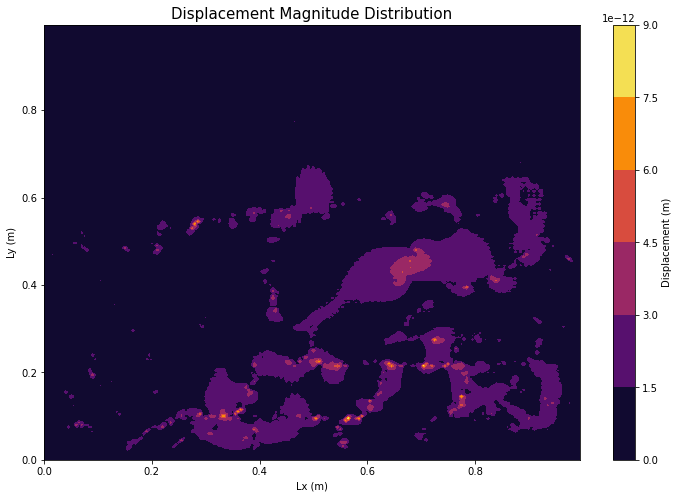

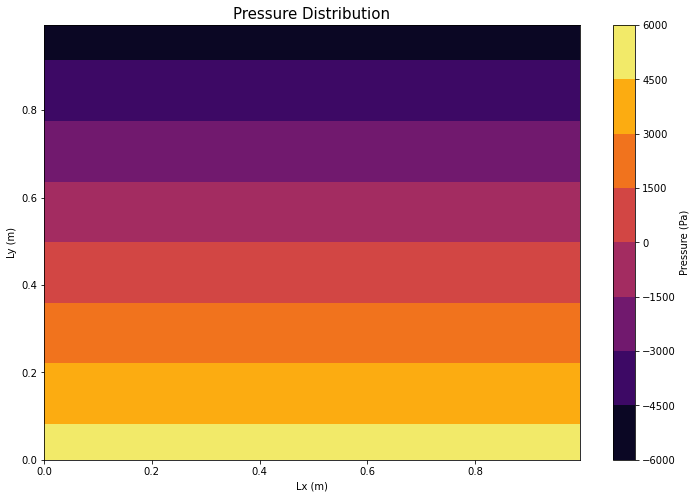

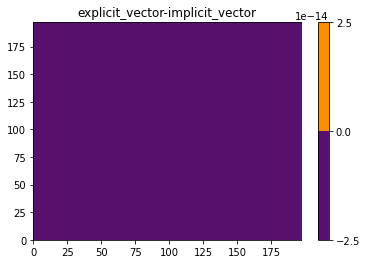

In [6]:
Lx = 1
Ly = 1

Nx = 200

Ny =200
dx = Lx/Nx
dy = Ly/Ny

dt = 0.1
xcoord = np.arange(dx/2,Lx,dx, dtype=float)
ycoord = np.arange(dy/2,Ly,dy, dtype=float)
shear = 1e6
rho = 1102
vin = np.array([0,0])
scaleFactor = 0
max_its = 1
relax_factor = 1
disp,p,v= CSD(Lx,Ly,Nx,Ny,shear,rho, vin,scaleFactor,dt,max_its,relax_factor)

# Gather Results

In [7]:
dir_name = Path("Master Results")
dir_name.mkdir(parents=True, exist_ok=True)

## Pressure midway through Block

Assuming previous ran simulation

In [7]:
abaqus_pressure = np.linspace(5378.28,-5378.28, Nx)

In [8]:
ycoord = np.arange(dy/2,Ly,dy, dtype=float)
xcoord = np.arange(dx/2,Lx,dx, dtype=float)

In [13]:
def pressure_block_centre(abaqus_pressure,python_pressure,Nx,savefig):
    bot = ceil(Nx/2)-1 #middle cell bottom of block
    top = Nx*Ny-1-bot #middle cell top of block
    cells = np.arange(bot,top,Nx)#cells along middle of block
    
    rel_error = 100*(python_pressure[cells]-abaqus_pressure.reshape(Nx,1))/abaqus_pressure.reshape(Nx,1)
    print("average relative error: %.6f "%(np.mean(rel_error)))
    print("maximum relative error: %.6f "%(np.max(rel_error)))
    plt.figure()
    plt.plot(abaqus_pressure,ycoord, 'b',python_pressure[cells],ycoord, 'ko', markersize = 1.5)
    plt.title('Pressure down centre of block', fontsize = 14, weight = 500)
#     plt.xlabel('Cells at 80% of Channel Length', fontsize = 12, weight = 600)
    plt.xlabel('Pressure (Pa)', fontsize = 12, weight = 500)
    plt.ylabel('Distance along y-axis (m)', fontsize = 12, weight = 500)
    plt.legend(['Abaqus', 'FVM'])
    if savefig:
        plt.savefig('pMiddleBlock.png')

average relative error: 0.000072 
maximum relative error: 0.003111 


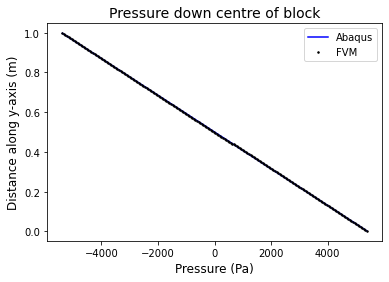

In [14]:
pressure_block_centre(abaqus_pressure,p,Nx,True)

## VTK Format

In [10]:


from pathlib import Path
dir_vtk = Path("usableVTK")
dir_vtk.mkdir(parents=True, exist_ok=True)


preamble = '# vtk DataFile Version 2.0\nTube Example\nASCII \n' 
Nz = 1
dx = Lx/Nx
dy = Ly/Ny
ycoord = np.arange(0,Ly+dy,dy, dtype=float)
xcoord = np.arange(0,Lx+dx,dx, dtype=float)
zcoord = np.array([0,1])
fname = 'solidBlock.vtk'
with open(dir_vtk/fname, "w") as f:
        f.write(preamble)
        f.write('DATASET STRUCTURED_GRID DIMENSIONS %i %i %i\n'%(Nx+1,Ny+1,Nz))
        f.write('POINTS %i float\n' %((Nx+1)*(Ny+1)))
        count = 0
            
        for y in ycoord:
            for x in xcoord:
#                 count+=1
                f.write('%f %f 0.0 \n' %(x,y))
                
        f.write('CELL_DATA %i\n'%((Nx)*(Ny)))
        f.write('SCALARS Deformation(m) float 1\nLOOKUP_TABLE default\n')
        for d in disp:
#             print(1e5*vel)
            f.write('%.8f\n'%(d))
    
#         f.write('CELL_DATA %i\n'%((Nx)*(Ny)))
        f.write('SCALARS Pressure(Pa) float 1\nLOOKUP_TABLE default\n')
        for pe in p:
            f.write('%.8f\n'%(pe))
            
#         f.write('VECTORS Velocity(1e11m/s) float\n')
# #         f.write('LOOKUP_TABLE default\n')
#         for i in range(0,len(v)-1,3):
#             f.write('%f %f 0\n'%(1e11*v[i],1e11*v[i+1]))
        
        
            
#        `

In [11]:
max(p)

array([5368.52357838])